In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import ast
!pip install joblib
!pip install openai==0.28.0
!pip install optuna-integration
!pip install scikit-learn
!pip install xgboost 
!pip install optuna-integration
!pip install pandas  hdbscan tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.9 MB/s eta 0:00:0000:0100:01


In [7]:

import pandas as pd
import re
from tqdm import tqdm
import time
import openai
import json
import pandas as pd
import matplotlib.pyplot as plt


openai.api_key = ''


# Abstract:
This Jupyter Notebook is designed to:

* Tag Conversations: Identify and label conversation segments.
* Vectorize Texts: Use OpenAI embeddings for vectorization.
* Train an XGBoost Classifier: Categorize conversations into specific, ad hoc classes.
* 
You can use it in your own chatbot script on any platform, but it is intended as complete from the repository: https://github.com/santiagocanepa/ChatBot_Facebook_IA.

* Usage Guidelines:

Initial Setup: Follow this notebook’s logic to tag and classify conversations.
Existing Systems: If you already have an active chatflow or have been using the script for a while, this notebook can still help. However, it’s more efficient to first filter your conversations with a regex (similar to the one in the puppeteer script). For example, you might exclude the responseinit1 tag in conversations that already contain that text.
Customization: You can modify the classes, tags, or categories to suit your process. Just remember to update these changes in both the notebook and the puppeteer script where they are referenced.
Model Specialization: The provided Python script can route conversations to different classification models based on tags (e.g., sending texts with responseinit1 to one model and responseinit2 to another), which reduces the number of classes and improves accuracy.
Use this notebook if your conversations lack a prior chatflow or automated response system that identifies patterns.

# Label/Category get

## Load your conversation json provided by facebook, this json does not always have the same format, so it may require some transformation, in this case it is a simple dictionary.

In [6]:
# Load JSON data
json_path = '/kaggle/input/conversations/conversations.json'  # Verify correct path
with open(json_path, 'r', encoding='utf-8') as file:
    conversation_data = json.load(file)

# Extract unique conversations
def extract_conversations_to_dataframe(json_data):
    """
    Extract conversation texts from JSON and create DataFrame with unique entries.
    
    Args:
    - json_data (list): List of dictionaries containing conversation data
    
    Returns:
    - pd.DataFrame: DataFrame with unique conversation texts
    """
    try:
        # Extract all conversation texts
        conversations = [entry.get('conversation', '') for entry in json_data]
        # Get unique conversations preserving order
        unique_conv = pd.unique(conversations)
        return pd.DataFrame({'conversation': unique_conv})
    except Exception as e:
        print(f"Error processing JSON: {e}")
        return pd.DataFrame(columns=['conversation'])

# Create DataFrame with unique conversations
df_conversations = extract_conversations_to_dataframe(conversation_data)
print("DataFrame Information:")
print(df_conversations.info())

print("\nFirst rows of the DataFrame:")
print(df_conversations.head())

print("\nBasic statistics for non-numeric data:")
print(df_conversations.describe(include=[object]))

print("\nCheck for null values in the DataFrame:")
print(df_conversations.isnull().sum())



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  5611 non-null   object
dtypes: object(1)
memory usage: 44.0+ KB
None

First rows of the DataFrame:
                                        conversation
0  {Oferta Inicial}\nHola tenés fotos\nLibre de t...
1  {Oferta Inicial}\nHola y 200mil si\n{Fotos env...
2  {Oferta Inicial}\nBuenos días, si aún lo tengo...
3  {Oferta Inicial}\nHola cómo estás?\nEste iPhon...
4  {Oferta Inicial}\nTe lo recibimos por parte de...

Basic statistics for non-numeric data:
                        conversation
count                           5611
unique                          4666
top     {Oferta Inicial}\nNo gracias
freq                              67

Check for null values in the DataFrame:
conversation    0
dtype: int64


## Define system_prompt

In [ ]:
# Define system_prompt
SYSTEM_PROMPT = """
Your task is to act as a wizard to tag prospect/company conversations within the following categories.
You will receive an extracted conversation that you should assign to one of the following categories:
“Noti": conversations that require the intervention of the sales manager, this is typically used in more advanced instances of the conversation, or in cases where the prospect shows significant interest.
“responseinit1": This category should be assigned for initial instances of conversation, at the prospect's first question.
“responsetwo": This category should be assigned for conversations that are in second message, that is after the salesperson or company gave the first response, and in cases where the prospect shows moderate interest, since if the interest is significant, as you know it should go to Noti.
“Null": This category should only be used when after receiving an answer from the seller, the prospect retracts, either because he sent the query by mistake or is not interested.
“SendDoc": This category should be assigned in cases where a response has already been sent, where the prospect is usually asked if he/she can be called, and he/she prefers to receive information by this means.

You should format your output as follows:

<thinking>
1. Read and analyze the meaning of the conversation you have received.
2. Make a plan (not executed) to determine into which category that converse would fall.
3. Execute the plan by providing only the category under “category”.
</p> <p>Thought

<category> Category assigned </category>.

""""

## Configuring the use of the api

In [ ]:
# Classification function
def classify_conversation(conversation_text, system_prompt, max_retries=5, sleep_time=20):
    """
    Classify conversation using OpenAI API.
    
    Args:
        conversation_text (str): Text to classify
        system_prompt (str): System prompt for classification
        max_retries (int): Maximum API retries
        sleep_time (int): Retry delay in seconds
    
    Returns:
        dict: Classification results with category and confidence
    """
    truncated_text = conversation_text[:12000]  # Truncate to ~12k characters (~3k tokens)
    
    for attempt in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"Conversation: {truncated_text}"}
                ],
                temperature=0
            )
            answer = response.choices[0].message['content']

            # Parse response
            category_match = re.search(r"<category>\s*(.*?)\s*</category>", answer, re.IGNORECASE)

            if category_match and confidence_match:
                return {
                    'category': category_match.group(1).strip(),
                }
            raise ValueError("Missing XML tags in response")
            
        except Exception as e:
            print(f"Error processing conversation: {str(e)[:200]}")
            if attempt < max_retries - 1:
                print(f"Retrying in {sleep_time}s... (Attempt {attempt+1}/{max_retries})")
                time.sleep(sleep_time)
    
    return {'category': 'Unknown'}

## Obtaining and visualizing results

In [12]:
# Parallel processing
results = []
with ThreadPoolExecutor(max_workers=5) as executor:  # Reduced workers for safety
    futures = {executor.submit(
        classify_conversation, 
        row.conversation, 
        SYSTEM_PROMPT
    ): idx for idx, row in df_conversations.iterrows()}

    for future in tqdm(as_completed(futures), total=len(futures)):
        idx = futures[future]
        try:
            results.append((idx, future.result()))
        except Exception as e:
            print(f"Failed processing index {idx}: {str(e)[:200]}")
            results.append((idx, {'category': 'Unknown', 'confidence': 0}))

# Add results to DataFrame
for idx, res in results:
    df_conversations.loc[idx, 'category'] = res['category']
    df_conversations.loc[idx, 'confidence'] = res['confidence']

# Display results
print("\nClassification Results:")
print(df_conversations.head(10))
print(f"\nTotal conversations processed: {len(df_conversations)}")


Classification Results:
                                        conversation       category
0  {Oferta Inicial}\nHola tenés fotos\nLibre de t...    responsetwo
1  {Oferta Inicial}\nHola y 200mil si\n{Fotos env...    responsetwo
2  {Oferta Inicial}\nBuenos días, si aún lo tengo...    responsetwo
3  {Oferta Inicial}\nHola cómo estás?\nEste iPhon...    responsetwo
4  {Oferta Inicial}\nTe lo recibimos por parte de...    responsetwo
5  {Oferta Inicial}\n200mil de DIF\n{Fotos enviad...    responsetwo
6  {Oferta Inicial}\nHola cómo estás ? Tenes foto...    responsetwo
7  {Oferta Inicial}\nHola Felipe qué tal buenas!,...    responsetwo
8  {Oferta Inicial}\nBuenas!\nSe vendio ese\n13 p...  responseinit1
9  {Oferta Inicial}\nHola buenas\nMandame\n221317...    responsetwo

Total conversations processed: 5611


In [17]:
category_distribution = df_conversations['category'].value_counts(dropna=False)

print("Distributión of category:")
print(category_distribution.to_string())  # to_string() para mejor formato


Distributión of category:
category
responseinit1    2795
responsetwo      2200
SendDoc           568
Noti               48


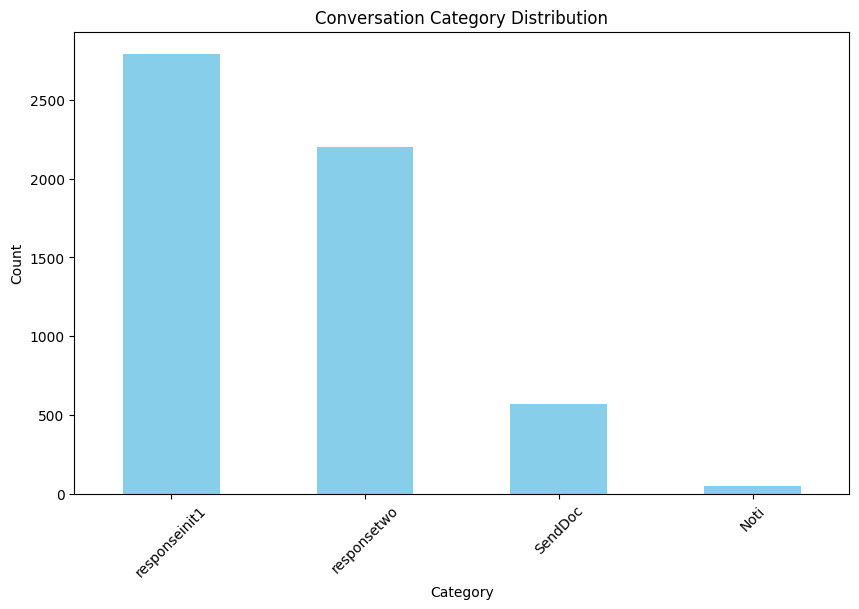

In [18]:
import matplotlib.pyplot as plt

# Gráfico de barras
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar', color='skyblue')
plt.title('Conversation Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Embeddings get

## Tuning the use of api embeddings
* En este caso utilizaremos los embeddings de open AI del modelo large, 3072 dimensiones, puede usar tambien el modelo ADA-02 de 1536 dimensiones, realmente no hay mucha diferencia. 

In [24]:
import pandas as pd
import numpy as np
import openai
import time
from tqdm import tqdm

# Validate required columns
assert 'conversation' in df.columns, "CSV missing 'conversation' column"
assert 'category' in df.columns, "CSV missing 'category' column"

# Model configuration
EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_DIM = 3072  # Dimension for specified model
MAX_TEXT_LENGTH = 2048  # Character limit for API input

# Rate limiting parameters
MAX_RETRY_ATTEMPTS = 5
RETRY_DELAY = 1  # Seconds between attempts
API_REQUEST_DELAY = 0.1  # Conservative safety margin

def generate_batch_embeddings(text_batch, model=EMBEDDING_MODEL):
    """Generate embeddings for a batch of text inputs."""
    processed_texts = [
        text.strip()[:MAX_TEXT_LENGTH] 
        for text in text_batch 
        if isinstance(text, str) and text.strip()
    ]
    
    if not processed_texts:
        return []
    
    try:
        response = openai.Embedding.create(
            input=processed_texts,
            model=model,
            encoding_format="float"  # Explicit format specification
        )
        return [np.array(item['embedding']) for item in response['data']]
    except Exception as error:
        print(f"Embedding generation failed: {error}")
        return [np.zeros(EMBEDDING_DIM) for _ in processed_texts]

def determine_segment_weights(text_length):
    """Calculate weighting factors based on conversation length."""
    if text_length <= 20:
        return (0.35, 0.65)
    elif text_length <= 50:
        return (0.45, 0.55)
    return (0.70, 0.30)

def compute_weighted_embedding(full_text, model=EMBEDDING_MODEL):
    """Generate context-weighted embedding for a conversation."""
    conversation_segments = full_text.split('\n')
    previous_dialog = '\n'.join(conversation_segments[:-1])
    final_exchange = conversation_segments[-1]
    
    word_count = len(full_text.split())
    context_weight, recent_weight = determine_segment_weights(word_count)
    
    # Generate embeddings for conversation components
    recent_embedding = generate_batch_embeddings([final_exchange], model=model)
    context_embedding = generate_batch_embeddings([previous_dialog], model=model) if previous_dialog else [np.zeros(EMBEDDING_DIM)]
    
    # Validate embedding dimensions
    if len(recent_embedding[0]) != len(context_embedding[0]):
        raise ValueError("Embedding dimension mismatch")
    
    # Calculate weighted combination
    combined_embedding = (
        context_weight * context_embedding[0] +
        recent_weight * recent_embedding[0]
    )
    return combined_embedding

# Generate embeddings with progress tracking
embedding_results = []

for conversation_text in tqdm(
    df['conversation'],
    desc="Generating conversation embeddings",
    unit="convo"
):
    if not isinstance(conversation_text, str) or not conversation_text.strip():
        embedding_results.append(np.zeros(EMBEDDING_DIM).tolist())
        continue

    current_attempt = 0
    while current_attempt < MAX_RETRY_ATTEMPTS:
        try:
            embedding = compute_weighted_embedding(conversation_text)
            embedding_results.append(embeddings.tolist())
            break
        except Exception as error:
            print(f"Attempt {current_attempt+1} failed: {str(error)[:200]}")
            current_attempt += 1
            time.sleep(RETRY_DELAY)
    else:
        print(f"Failed after {MAX_RETRY_ATTEMPTS} attempts, using zero vector")
        embedding_results.append(np.zeros(EMBEDDING_DIM).tolist())
    
    time.sleep(API_REQUEST_DELAY)  # Rate limit protection

# Add embeddings to dataframe
df['embeddings'] = embedding_results

# Save results
output_filename = "conversations_with_embeddings"
df.to_csv(output_filename, index=False)

print(f"Processing complete. Results saved to {output_filename}")

Processing complete. Results saved to conversations_with_embeddings.csv


## Testing results

In [23]:

# Load generated CSV
df = pd.read_csv('/kaggle/working/conversations_with_embeddings.csv')


# Initial data inspection
print("Data Preview:")
print(df.head(3))

# Column validation
REQUIRED_COLUMNS = ['conversation', 'category', 'embeddings']
existing_columns = df.columns.tolist()
missing_cols = [col for col in REQUIRED_COLUMNS if col not in existing_columns]

if missing_cols:
    print(f"🔴 Missing critical columns: {missing_cols}")
else:
    print("✅ All required columns present")

# Null value analysis
null_report = df[REQUIRED_COLUMNS].isnull().sum()
if null_report.any():
    print("\n🔴 Null values detected:")
    print(null_report[null_report > 0])
    print("\nSample rows with nulls:")
    print(df[df.isnull().any(axis=1)].head(2))
else:
    print("\n✅ No null values found")

Data Preview:
                                        conversation     category  \
0  {Oferta Inicial}\nHola tenés fotos\nLibre de t...  responsetwo   
1  {Oferta Inicial}\nHola y 200mil si\n{Fotos env...  responsetwo   
2  {Oferta Inicial}\nBuenos días, si aún lo tengo...  responsetwo   

                                          embeddings  
0  [-0.03501860424876213, 0.013519452884793282, 0...  
1  [-0.003209846094250679, 0.06352680921554565, -...  
2  [-0.020242588594555855, 0.010730857960879803, ...  
✅ All required columns present

✅ No null values found


In [26]:

# Embedding validation
EMBEDDING_DIMENSION = 3072

def validate_embedding(embedding_str, expected_dim=EMBEDDING_DIMENSION):
    """Verify embedding structure and dimensionality"""
    try:
        vector = ast.literal_eval(embedding_str)
        if isinstance(vector, list) and len(vector) == expected_dim:
            return True
        return False
    except:
        return False

# Apply embedding validation
df['valid_embedding'] = df['embeddings'].apply(validate_embedding)
embedding_validation = df['valid_embedding'].value_counts()

print(f"\nEmbedding Quality Report:")
print(f"✅ Valid embeddings: {embedding_validation.get(True, 0)}")
print(f"🔴 Invalid embeddings: {embedding_validation.get(False, 0)}")

if not embedding_validation.all():
    print("\nSample invalid embeddings:")
    print(df[~df['valid_embedding']][['conversation', 'embeddings']].head(2))

# Comprehensive summary
print("\n🔍 Data Validation Summary 🔍")
print("----------------------------")
print(f"1. Required Columns: {REQUIRED_COLUMNS}")
print(f"2. Missing Columns: {missing_cols if any(missing_cols) else 'None'}")
print(f"3. Null Values:\n{null_report.to_string()}")
print(f"4. Valid Embeddings: {embedding_validation.get(True, 0)}/{len(df)}")
print(f"5. Invalid Embeddings: {embedding_validation.get(False, 0)}/{len(df)}")
print("✅ Validation complete" if embedding_validation.all() else "⚠️ Validation issues found")


Embedding Quality Report:
✅ Valid embeddings: 5611
🔴 Invalid embeddings: 0

🔍 Data Validation Summary 🔍
----------------------------
1. Required Columns: ['conversation', 'category', 'embeddings']
2. Missing Columns: None
3. Null Values:
conversation    0
category        0
embeddings      0
4. Valid Embeddings: 5611/5611
5. Invalid Embeddings: 0/5611
✅ Validation complete


# Preparing the training of the model
## Creating the variables and the label encoder to store them.

In [9]:
import pandas as pd
import numpy as np
import ast
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import os

df = pd.read_csv('/kaggle/working/conversations_with_embeddings')

def convert_embeddings(embedding_str):
    try:
        return ast.literal_eval(embedding_str)
    except (ValueError, SyntaxError):
        return []

df['embeddings'] = df['embeddings'].apply(convert_embeddings)

EXPECTED_EMBEDDING_LENGTH = 3072
df = df[df['embeddings'].apply(lambda x: isinstance(x, list) and len(x) == EXPECTED_EMBEDDING_LENGTH)]

X = df['embeddings'].tolist()
X = np.array(X)  # transform to numpy array 
y = df['category'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

joblib.dump(label_encoder, 'label_encoder.pkl')
print("🔒 LabelEncoder guardado como 'label_encoder.pkl'.")


🔒 LabelEncoder guardado como 'label_encoder.pkl'.


## Hyperparameter Tuning (First Stage):



* Verify and split the data in a stratified way.
* Defines a hyperparameter optimization function for XGBoost with cross-validation.
* Set up and run an optimization study (150 trials) and print out the best parameters.

In [11]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Data preparation checks
assert X.shape[0] == y_encoded.shape[0], "Feature-target dimension mismatch"
print(f"📊 Dataset dimensions - Features: {X.shape}, Targets: {y_encoded.shape}")

# Stratified data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

def optimize_hyperparameters(trial):
    """Optuna optimization objective for XGBoost parameters"""
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_encoded)),
        'tree_method': 'gpu_hist',
        'eval_metric': 'mlogloss',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'learning_rate': trial.suggest_float('lr', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('alpha', 0, 10),
        'reg_lambda': trial.suggest_float('lambda', 0, 10)
    }
    
    # Conditional parameter space
    if params['max_depth'] > 8:
        params['gamma'] = trial.suggest_float('gamma', 0, 5)
    
    model = xgb.XGBClassifier(**params)
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=3, scoring='accuracy', n_jobs=-1
    )
    return np.mean(cv_scores)

# Optimization setup
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(),
    study_name="conversation_clf_optimization"
)

print("🚀 Starting hyperparameter optimization...")
study.optimize(optimize_hyperparameters, n_trials=150)

# Best parameters output
best_params = study.best_params
print("🎯 Best parameters:")
for k, v in best_params.items():
    print(f"{k:>15}: {v}")

[I 2025-02-16 22:53:41,328] A new study created in memory with name: conversation_clf_optimization


📊 Dataset dimensions - Features: (5611, 3072), Targets: (5611,)
🚀 Starting hyperparameter optimization...


[I 2025-02-16 22:53:57,064] Trial 0 finished with value: 0.7560160427807486 and parameters: {'n_estimators': 175, 'max_depth': 12, 'lr': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample': 0.7468055921327309, 'alpha': 1.5599452033620265, 'lambda': 0.5808361216819946, 'gamma': 4.330880728874676}. Best is trial 0 with value: 0.7560160427807486.
[I 2025-02-16 22:54:53,512] Trial 1 finished with value: 0.75222816399287 and parameters: {'n_estimators': 220, 'max_depth': 10, 'lr': 0.010725209743171997, 'subsample': 0.9909729556485982, 'colsample': 0.9497327922401265, 'alpha': 2.1233911067827616, 'lambda': 1.8182496720710062, 'gamma': 0.9170225492671691}. Best is trial 0 with value: 0.7560160427807486.
[I 2025-02-16 22:55:12,659] Trial 2 finished with value: 0.7609180035650623 and parameters: {'n_estimators': 161, 'max_depth': 9, 'lr': 0.04345454109729477, 'subsample': 0.7873687420594125, 'colsample': 0.8835558684167139, 'alpha': 1.3949386065204183, 'lambda': 2.9214464853521815,

🎯 Best parameters:
   n_estimators: 235
      max_depth: 6
             lr: 0.2244760914888079
      subsample: 0.7425763349320388
      colsample: 0.8124238329057876
          alpha: 0.024843530284000256
         lambda: 4.480269541695075


## Final Model Training (Second Stage):


* Next, using the best hyperparameters, we will evaluate models with different weights on the minority classes, which are the relevant ones. The central objective is to have a recall of 100 in Noti, i.e. 0 false negatives and as few as possible in SendDoc. 

In [12]:
encoded_labels = label_encoder.classes_

print("Labels and Values")
for index, label in enumerate(encoded_labels):
    print(f"{label}: {index}")

Labels and Values
Noti: 0
SendDoc: 1
responseinit1: 2
responsetwo: 3



🔧 Training with weight configuration: balanced_weights


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample", "lr" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


               precision    recall  f1-score   support

         Noti       0.03      0.90      0.06        10
      SendDoc       0.80      0.75      0.77       114
responseinit1       0.91      0.69      0.78       559
  responsetwo       0.78      0.55      0.64       440

     accuracy                           0.64      1123
    macro avg       0.63      0.72      0.57      1123
 weighted avg       0.84      0.64      0.72      1123

💾 Saved model: conversation_clf_balanced_weights.pkl


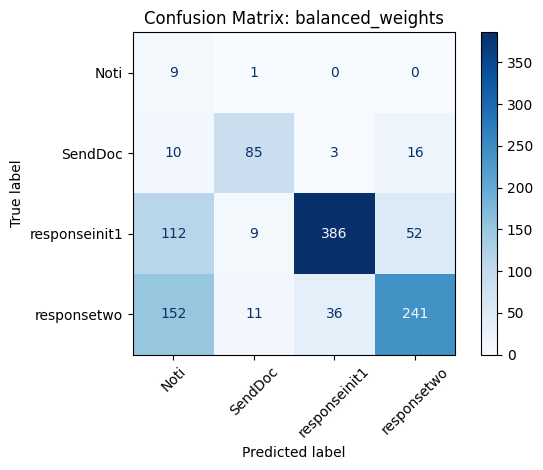


🔧 Training with weight configuration: focus_minority


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample", "lr" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


               precision    recall  f1-score   support

         Noti       0.03      0.90      0.06        10
      SendDoc       0.74      0.83      0.79       114
responseinit1       0.93      0.65      0.76       559
  responsetwo       0.76      0.55      0.64       440

     accuracy                           0.63      1123
    macro avg       0.61      0.73      0.56      1123
 weighted avg       0.83      0.63      0.71      1123

💾 Saved model: conversation_clf_focus_minority.pkl


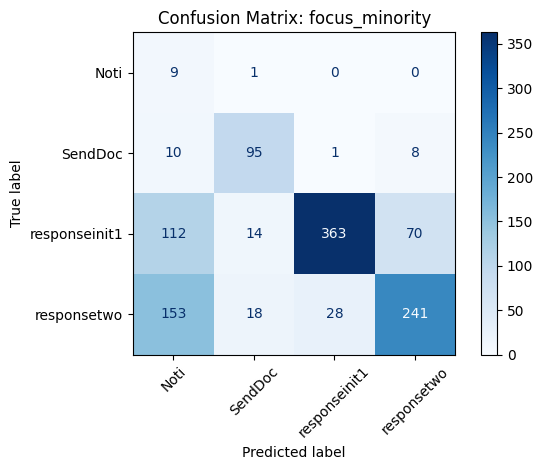


🔧 Training with weight configuration: aggressive_recall


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample", "lr" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


               precision    recall  f1-score   support

         Noti       0.03      1.00      0.07        10
      SendDoc       0.56      0.90      0.69       114
responseinit1       0.93      0.60      0.73       559
  responsetwo       0.75      0.50      0.60       440

     accuracy                           0.59      1123
    macro avg       0.57      0.75      0.52      1123
 weighted avg       0.81      0.59      0.67      1123

💾 Saved model: conversation_clf_aggressive_recall.pkl


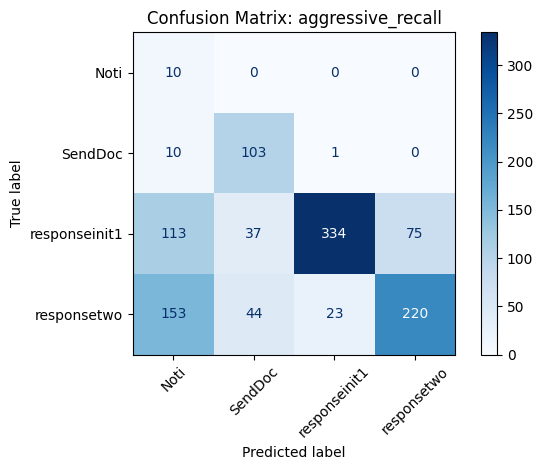

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Enhanced class weighting strategies
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_encoded), 
    y=y_encoded
)

weight_configs = [
    {
        'name': 'balanced_weights',
        'weights': {i: w for i, w in enumerate(class_weights)}
    },
    {
        'name': 'focus_minority',
        'weights': {0: 0.85, 1: 0.13, 2: 0.009, 3: 0.011}
    },
    {
        'name': 'aggressive_recall',
        'weights': {0: 0.95, 1: 0.045, 2: 0.002, 3: 0.003}
    }
]

for config in weight_configs:
    print(f"\n🔧 Training with weight configuration: {config['name']}")
    
    model = xgb.XGBClassifier(
        **best_params,
        objective='multi:softmax',
        num_class=len(np.unique(y_encoded)),
        tree_method='gpu_hist'
    )
    
    sample_weights = np.array([config['weights'][cls] for cls in y_train])
    model.fit(X_train, y_train, sample_weight=sample_weights)
    
    # Enhanced evaluation
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Save conversation-specific model
    model_path = f"conversation_clf_{config['name']}.pkl"
    joblib.dump(model, model_path)
    print(f"💾 Saved model: {model_path}")

    # Confusion matrix visualization
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
        display_labels=label_encoder.classes_,
        cmap='Blues', xticks_rotation=45
    )
    plt.title(f"Confusion Matrix: {config['name']}")
    plt.tight_layout()
    plt.show()

# Conclusion: 


In this case, I will employ the aggressive recall model, as minimizing false negatives in Noti is essential for this type of business. I also place importance on recall in “SendDoc,” because an automated response at the appropriate time for sending documentation is critical.

I recommend following the same logic if your closure rate is below 1%. In such scenarios, prioritizing recall for the relevant classes is paramount. With a false negative rate of zero, filtering the initial two responses is highly beneficial—approximately 50% of the second responses were correctly labeled, and 59% in the case of the initial response.

To optimize this process in real-world applications, the Puppetier script includes a regex. If the prediction is either “responsetwo” or “SendDoc” but does not contain the designated text prefix and suffix of “responseinit1,” it will default to the latter, making the process straightforward.

In the case of Noti—where this protocol does not exist—I emphasize that “Noti” triggers a function that sends the conversation to the 4o-mini API. This API categorizes the conversation and either provides a response if the information is available or generates the actual notification to the seller. Essentially, this model is designed to optimize token usage by minimizing direct calls to the generative AI model.

